#  Intrusion Detection for Unix Processes

## Part 1: Preprocessing cert

First, we need to convert the training data to a file with only fixed sized substrings.

In [1]:
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import collections

In [2]:
def fixed_length_substring(file, K):
    train_substrings = []
    for train_str in file:
        for train_substr in range(0, len(train_str), K):
            new_substr = train_str[0+train_substr:train_substr+K]
            if len(new_substr) == K:
                train_substrings.append(new_substr)
    return list(set(train_substrings))

def write_file(l, name):
    new_str = ""
    for i in l:
        new_str = new_str + i + "\n"

    file = open(name, "w+")
    file.write(new_str)
    file.close()

    # K = 7 will perfectly fit AEEEEEE, the shortest training string
for K in [5, 6, 7]:
    train = np.loadtxt("snd-cert.train", dtype=str)
    new_train = fixed_length_substring(train, K) 
    write_file(new_train, "snd-cert-chunk"+str(K)+".train")

In [3]:
def fixed_length_substring_with_labels_a(labels, K):
    test_substrings = []
    for i in range(len(labels)): 
        for test_substr in range(0, len(labels[i]), K):
            new_substr = labels[i][0+test_substr:test_substr+K]
            if len(new_substr) == K:
                test_substrings.append([new_substr, i])
    a = list(zip(*test_substrings))[0]
    b = list(zip(*test_substrings))[1]
    d = collections.OrderedDict.fromkeys(zip(a,b))
    return [k[0] for k in d], [k[1] for k in d]

In [4]:
test = []
labels = []
new_test = []
new_labels = []
K_list = [5, 6, 7]
for K_idx in range(len(K_list)):
    test.append([])
    labels.append([])
    new_test.append([])
    new_labels.append([])
    for test_idx in [1, 2, 3]:
        test[K_idx].append(np.loadtxt("snd-cert."+str(test_idx)+".test", dtype=str))
        labels[K_idx].append(np.loadtxt("snd-cert."+str(test_idx)+".labels", dtype=str))
        new_test_a, new_labels_a = fixed_length_substring_with_labels_a(test[K_idx][test_idx - 1], K_list[K_idx])
        write_file(new_test_a, "snd-cert-chunka"+str(K_list[K_idx])+"."+str(test_idx)+".test")
        new_test[K_idx].append(new_test_a)
        new_labels[K_idx].append(new_labels_a)

## Part 2: Classification cert

Now we have the correct train and test files. The commands to be run can be found in the bash file.

As suggested in the assignment, we compute the number of matching patterns for each chunk separately, and merge these counts together to a composite anomaly score (for instance, you could average the individual counts)

In [5]:
def compute_anomaly_score(labels, new_labels, test):
    anomaly_score_per_string = []
    for i in range(len(labels)):
        count_per_string = 0
        substr_in_str = 0
        for j in range(len(new_labels)):
            if i == new_labels[j]:
                count_per_string += test[j]
                substr_in_str += 1
        anomaly_score_per_string.append(count_per_string / substr_in_str)
    return anomaly_score_per_string

In [6]:
def compute_roc_auc(test, labels):
    labels = [int(x) for x in labels] 
    anomaly_scores = list(zip(test, labels))
    anomaly_scores.sort(reverse=True)
    
    #split the list up into actual class (y) and anomaly score (y_pred)
    y = [y for [x,y] in anomaly_scores]
    y_pred = [x for [x,y] in anomaly_scores]

    #using the functions from sklearn to easily calculate the roc_curve
    fpr, tpr, threshold = metrics.roc_curve(y, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    return fpr, tpr, threshold, roc_auc

def plot_ROC(fpr, tpr, roc_auc, title = ''):
      #plotting the ROC
    plt.title('Receiver Operating Characteristic'+title)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

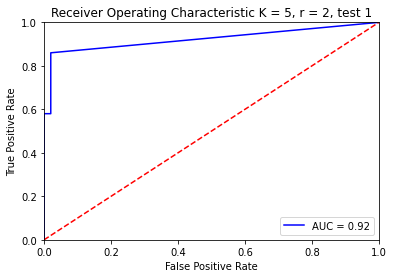

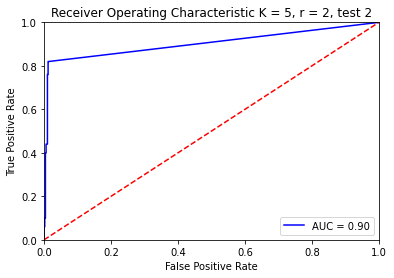

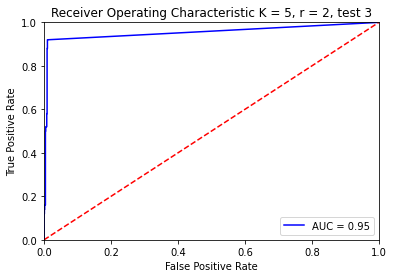

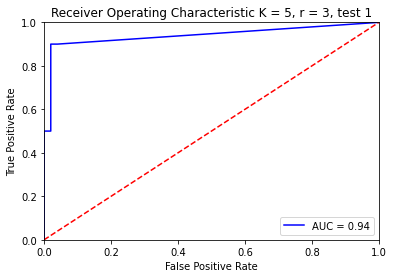

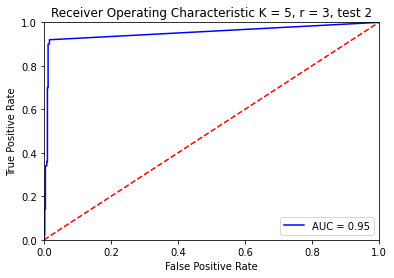

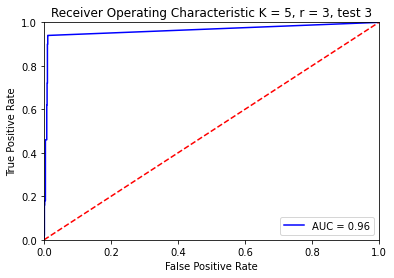

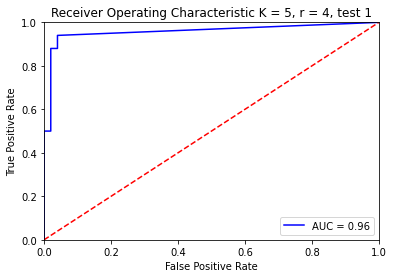

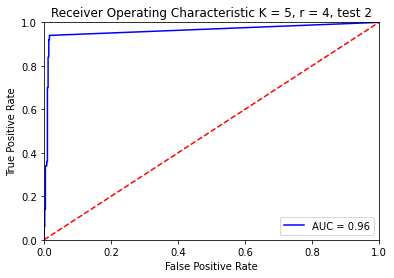

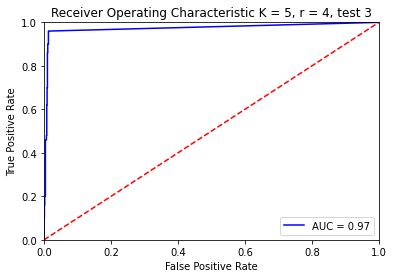

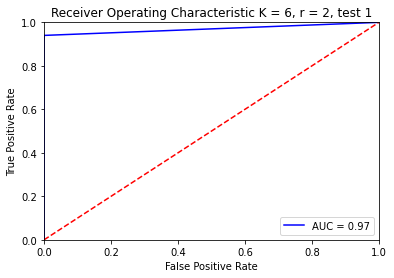

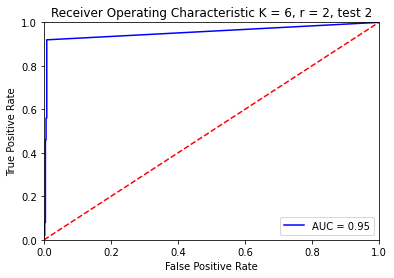

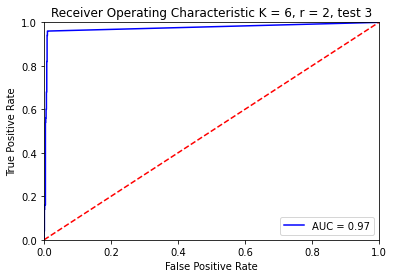

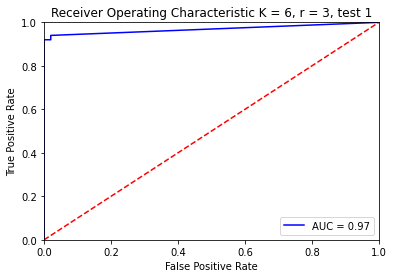

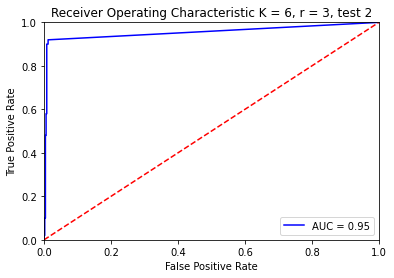

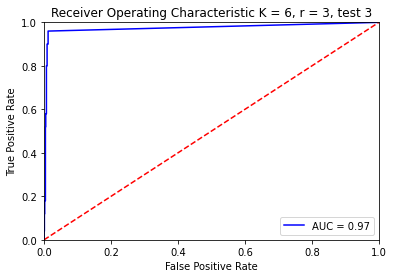

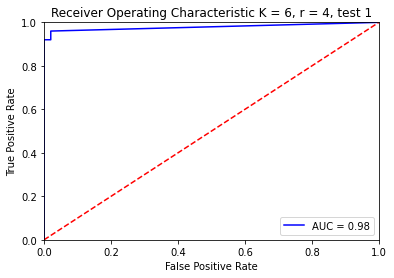

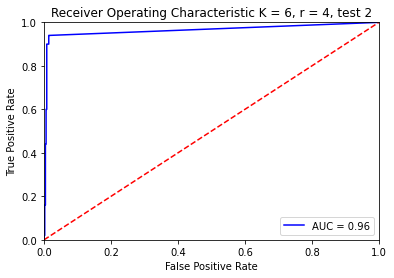

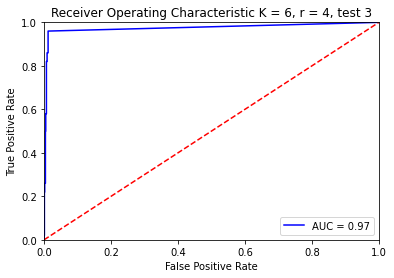

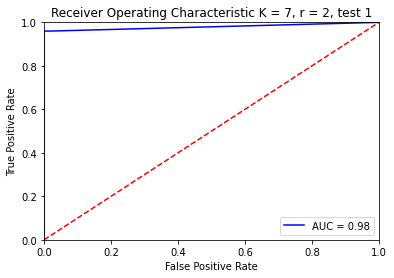

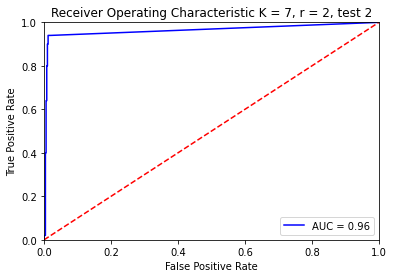

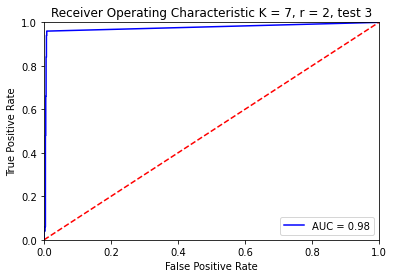

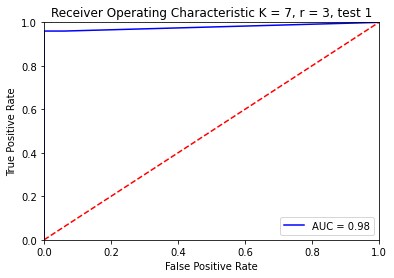

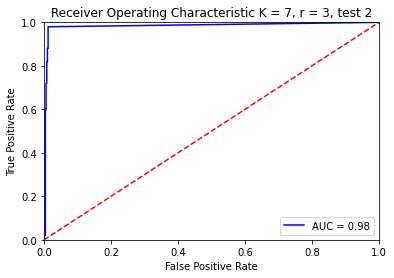

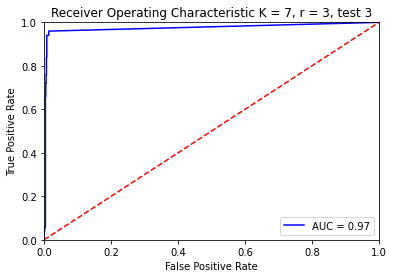

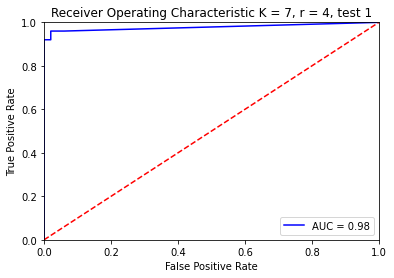

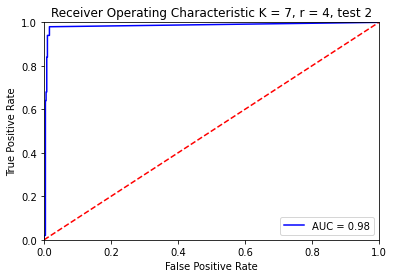

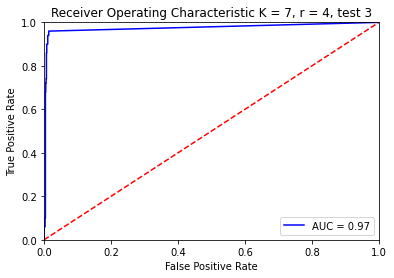

In [8]:
K_list = [5, 6, 7]
for K_idx in range(len(K_list)):
    for r in [2, 3, 4]:
        for test_idx in [1, 2, 3]:
            test = np.loadtxt("test_cert"+str(K_list[K_idx])+"_"+str(r)+"."+str(test_idx)+".txt", dtype=float)
            anomaly_scores = compute_anomaly_score(labels[K_idx][test_idx - 1], 
                                                   new_labels[K_idx][test_idx - 1], test)
            fpr, tpr, threshold, roc_auc = compute_roc_auc(anomaly_scores, labels[K_idx][test_idx - 1])
            plot_ROC(fpr, tpr, roc_auc, ' K = '+str(K_list[K_idx])+', r = '+str(r)+', test '+str(test_idx))

## Part 3: Preprocessing unm

In [9]:
K_list = [5, 6, 7]
train = np.loadtxt("snd-unm.train", dtype=str)
for K in K_list:
    new_train = fixed_length_substring(train, K) 
    write_file(new_train, "snd-unm-chunk"+str(K)+".train")

test = []
labels = []
new_test = []
new_labels = []

for K_idx in range(len(K_list)):
    test.append([])
    labels.append([])
    new_test.append([])
    new_labels.append([])
    for test_idx in [1, 2, 3]:
        test[K_idx].append(np.loadtxt("snd-unm."+str(test_idx)+".test", dtype=str))
        labels[K_idx].append(np.loadtxt("snd-unm."+str(test_idx)+".labels", dtype=str))
        new_test_a, new_labels_a = fixed_length_substring_with_labels_a(test[K_idx][test_idx - 1], K_list[K_idx])
        write_file(new_test_a, "snd-unm-chunka"+str(K_list[K_idx])+"."+str(test_idx)+".test")
        new_test[K_idx].append(new_test_a)
        new_labels[K_idx].append(new_labels_a)

## Part 4: Classification unm

Now we have the correct train and test files. The commands to be run can be found in the bash file.

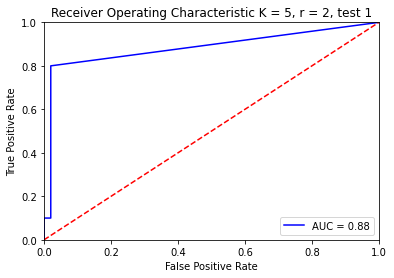

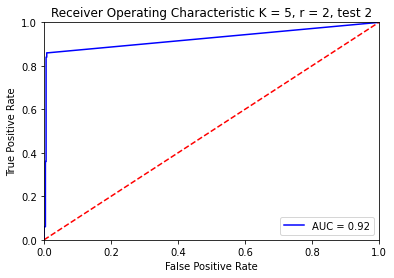

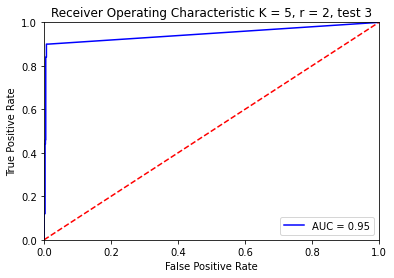

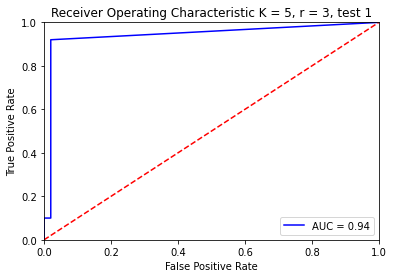

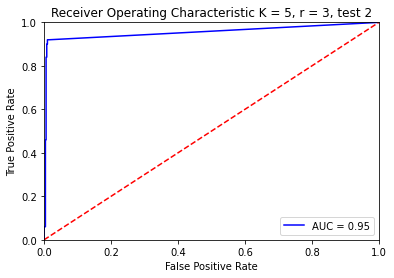

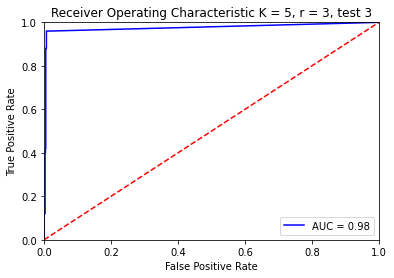

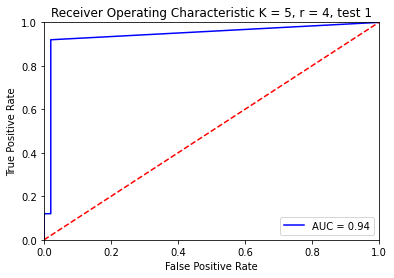

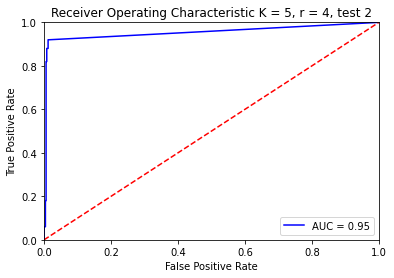

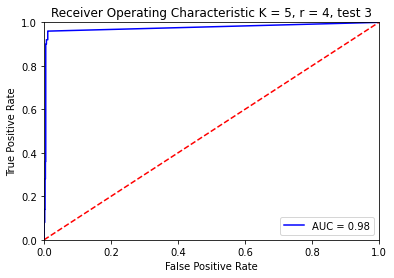

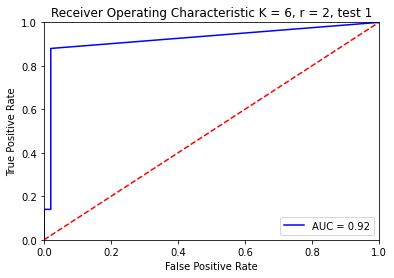

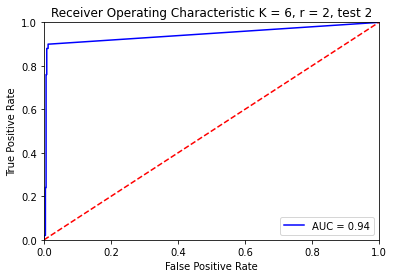

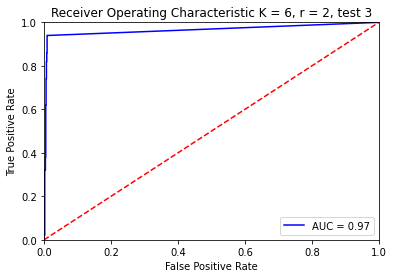

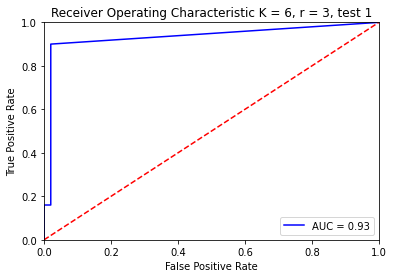

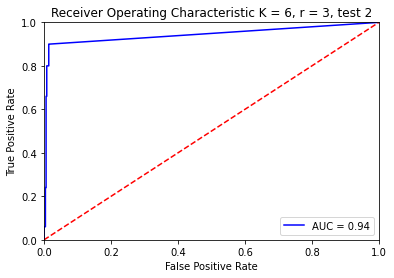

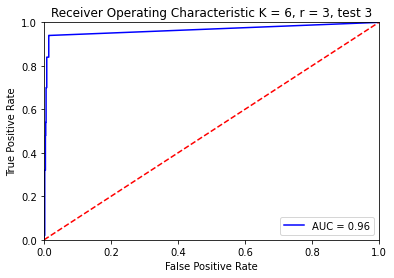

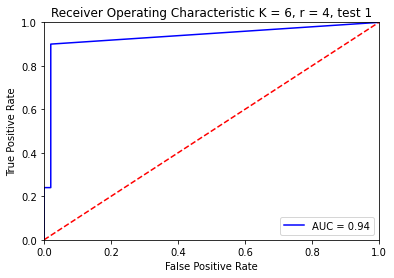

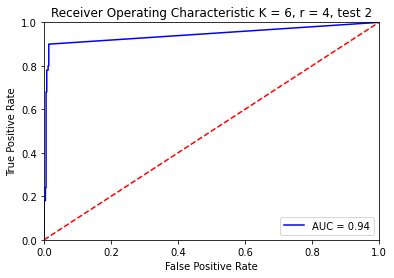

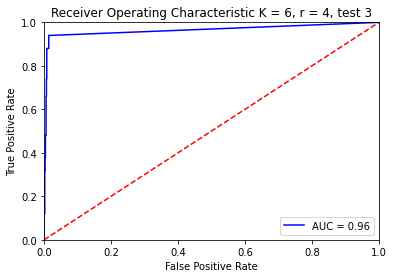

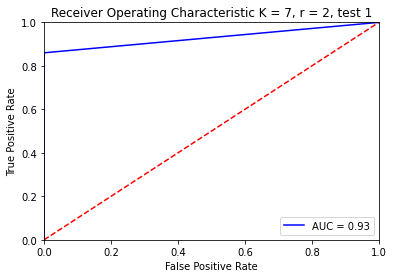

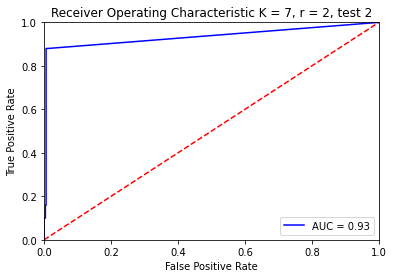

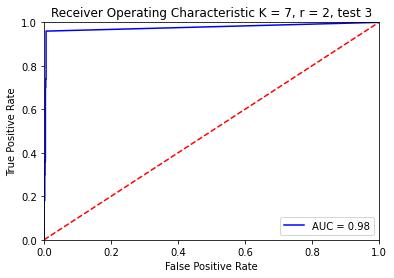

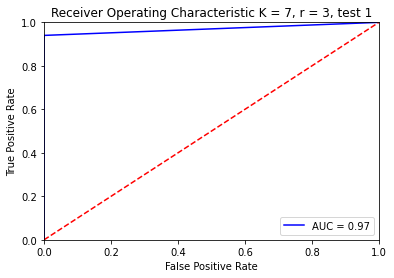

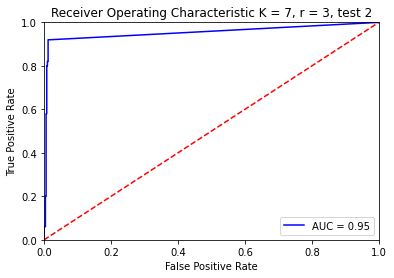

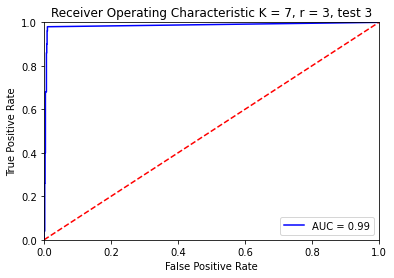

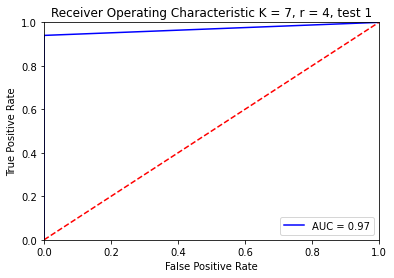

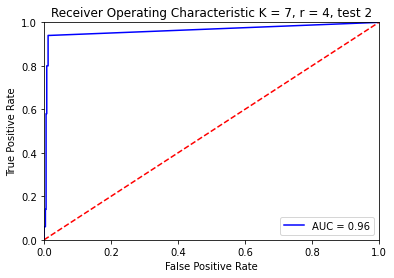

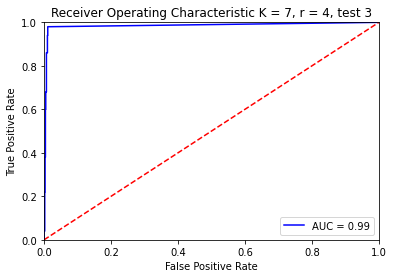

In [10]:
for K_idx in range(len(K_list)):
    for r in [2, 3, 4]:
        for test_idx in [1, 2, 3]:
            test = np.loadtxt("test_unm"+str(K_list[K_idx])+"_"+str(r)+"."+str(test_idx)+".txt", dtype=float)
            anomaly_scores = compute_anomaly_score(labels[K_idx][test_idx - 1], 
                                                   new_labels[K_idx][test_idx - 1], test)
            fpr, tpr, threshold, roc_auc = compute_roc_auc(anomaly_scores, labels[K_idx][test_idx - 1])
            plot_ROC(fpr, tpr, roc_auc, ' K = '+str(K_list[K_idx])+', r = '+str(r)+', test '+str(test_idx))